In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [5]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-05-20 15:15:05.496034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_02_bin1     2676486
                     ...   
TiteSeq_15_bin4      401678
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [10]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mp_list = [mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [12]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4285)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4221)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4222        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 74,560 observations set as training data.
Using 19.9% for validation.
Time to set data: 15.8 sec.


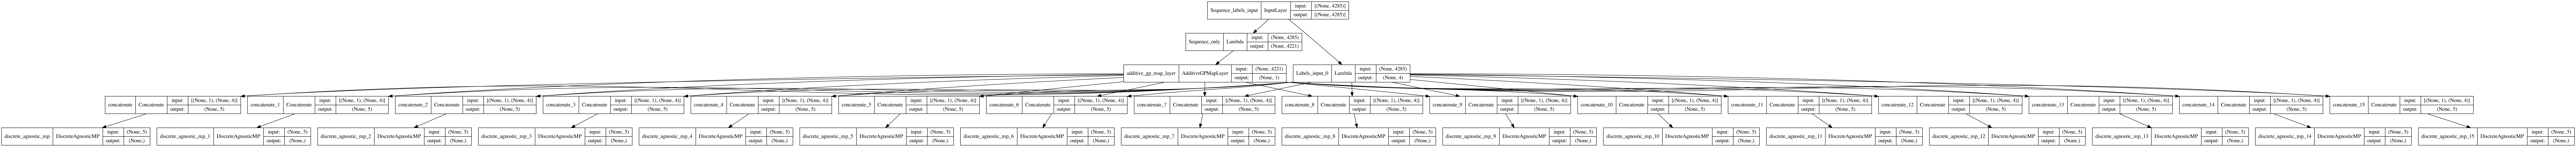

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='titeseq_dar.png')

In [17]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=1000,
          batch_size=500,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/1000
120/120 [==============================] - 19s 79ms/step - loss: 1110704.5000 - discrete_agnostic_mp_loss: 68869.7656 - discrete_agnostic_mp_1_loss: 69410.2422 - discrete_agnostic_mp_2_loss: 69824.7109 - discrete_agnostic_mp_3_loss: 69548.3594 - discrete_agnostic_mp_4_loss: 68862.2266 - discrete_agnostic_mp_5_loss: 69859.2266 - discrete_agnostic_mp_6_loss: 69485.2109 - discrete_agnostic_mp_7_loss: 68980.1562 - discrete_agnostic_mp_8_loss: 70116.4062 - discrete_agnostic_mp_9_loss: 69791.7344 - discrete_agnostic_mp_10_loss: 69598.6016 - discrete_agnostic_mp_11_loss: 69250.6797 - discrete_agnostic_mp_12_loss: 69321.9688 - discrete_agnostic_mp_13_loss: 69150.9844 - discrete_agnostic_mp_14_loss: 69028.5234 - discrete_agnostic_mp_15_loss: 69605.9766 - I_var: -0.8318 - val_loss: 1438662.0000 - val_discrete_agnostic_mp_loss: 89866.2500 - val_discrete_agnostic_mp_1_loss: 89935.0000 - val_discrete_agnostic_mp_2_loss: 89947.5078 - val_discrete_agnostic_mp_3_loss: 89939.2344 - val_dis

120/120 [==============================] - 4s 37ms/step - loss: 947102.1875 - discrete_agnostic_mp_loss: 59263.7109 - discrete_agnostic_mp_1_loss: 59225.5820 - discrete_agnostic_mp_2_loss: 59108.7734 - discrete_agnostic_mp_3_loss: 59118.1680 - discrete_agnostic_mp_4_loss: 59154.2305 - discrete_agnostic_mp_5_loss: 59181.6094 - discrete_agnostic_mp_6_loss: 59095.8594 - discrete_agnostic_mp_7_loss: 59167.8320 - discrete_agnostic_mp_8_loss: 59145.9492 - discrete_agnostic_mp_9_loss: 59208.5352 - discrete_agnostic_mp_10_loss: 59225.2891 - discrete_agnostic_mp_11_loss: 59325.8320 - discrete_agnostic_mp_12_loss: 59220.8125 - discrete_agnostic_mp_13_loss: 59254.5664 - discrete_agnostic_mp_14_loss: 59206.3984 - discrete_agnostic_mp_15_loss: 59198.8867 - I_var: -0.5809 - val_loss: 1227107.3750 - val_discrete_agnostic_mp_loss: 76869.5000 - val_discrete_agnostic_mp_1_loss: 76751.4141 - val_discrete_agnostic_mp_2_loss: 76551.6094 - val_discrete_agnostic_mp_3_loss: 76577.0703 - val_discrete_agnostic_

120/120 [==============================] - 5s 41ms/step - loss: 787287.8125 - discrete_agnostic_mp_loss: 49204.6250 - discrete_agnostic_mp_1_loss: 49205.7539 - discrete_agnostic_mp_2_loss: 49209.7656 - discrete_agnostic_mp_3_loss: 49210.2852 - discrete_agnostic_mp_4_loss: 49196.8555 - discrete_agnostic_mp_5_loss: 49209.1133 - discrete_agnostic_mp_6_loss: 49205.7773 - discrete_agnostic_mp_7_loss: 49199.7344 - discrete_agnostic_mp_8_loss: 49213.7266 - discrete_agnostic_mp_9_loss: 49212.0469 - discrete_agnostic_mp_10_loss: 49210.1250 - discrete_agnostic_mp_11_loss: 49200.6211 - discrete_agnostic_mp_12_loss: 49203.8789 - discrete_agnostic_mp_13_loss: 49199.3594 - discrete_agnostic_mp_14_loss: 49196.2461 - discrete_agnostic_mp_15_loss: 49209.6367 - I_var: -0.3364 - val_loss: 1070013.6250 - val_discrete_agnostic_mp_loss: 66901.7031 - val_discrete_agnostic_mp_1_loss: 66885.0234 - val_discrete_agnostic_mp_2_loss: 66873.2109 - val_discrete_agnostic_mp_3_loss: 66872.7031 - val_discrete_agnostic_

120/120 [==============================] - 5s 39ms/step - loss: 711727.3750 - discrete_agnostic_mp_loss: 44486.4883 - discrete_agnostic_mp_1_loss: 44484.1836 - discrete_agnostic_mp_2_loss: 44484.5078 - discrete_agnostic_mp_3_loss: 44487.7734 - discrete_agnostic_mp_4_loss: 44477.2070 - discrete_agnostic_mp_5_loss: 44484.0273 - discrete_agnostic_mp_6_loss: 44483.6602 - discrete_agnostic_mp_7_loss: 44479.3711 - discrete_agnostic_mp_8_loss: 44487.1914 - discrete_agnostic_mp_9_loss: 44489.6328 - discrete_agnostic_mp_10_loss: 44487.0508 - discrete_agnostic_mp_11_loss: 44477.3945 - discrete_agnostic_mp_12_loss: 44480.1719 - discrete_agnostic_mp_13_loss: 44478.4102 - discrete_agnostic_mp_14_loss: 44473.2383 - discrete_agnostic_mp_15_loss: 44486.9766 - I_var: -0.2157 - val_loss: 991605.0625 - val_discrete_agnostic_mp_loss: 62001.9531 - val_discrete_agnostic_mp_1_loss: 61981.2969 - val_discrete_agnostic_mp_2_loss: 61968.3086 - val_discrete_agnostic_mp_3_loss: 61978.6211 - val_discrete_agnostic_m

120/120 [==============================] - 5s 46ms/step - loss: 676020.1875 - discrete_agnostic_mp_loss: 42264.0586 - discrete_agnostic_mp_1_loss: 42255.5977 - discrete_agnostic_mp_2_loss: 42248.7266 - discrete_agnostic_mp_3_loss: 42253.9258 - discrete_agnostic_mp_4_loss: 42245.5000 - discrete_agnostic_mp_5_loss: 42250.1445 - discrete_agnostic_mp_6_loss: 42249.0703 - discrete_agnostic_mp_7_loss: 42247.9609 - discrete_agnostic_mp_8_loss: 42254.7305 - discrete_agnostic_mp_9_loss: 42257.8164 - discrete_agnostic_mp_10_loss: 42255.6562 - discrete_agnostic_mp_11_loss: 42246.1328 - discrete_agnostic_mp_12_loss: 42248.5742 - discrete_agnostic_mp_13_loss: 42247.6680 - discrete_agnostic_mp_14_loss: 42238.9727 - discrete_agnostic_mp_15_loss: 42255.3867 - I_var: -0.1640 - val_loss: 973216.8750 - val_discrete_agnostic_mp_loss: 60851.1641 - val_discrete_agnostic_mp_1_loss: 60834.5156 - val_discrete_agnostic_mp_2_loss: 60819.7344 - val_discrete_agnostic_mp_3_loss: 60829.1445 - val_discrete_agnostic_m

120/120 [==============================] - 8s 66ms/step - loss: 662318.5000 - discrete_agnostic_mp_loss: 41411.2617 - discrete_agnostic_mp_1_loss: 41400.4180 - discrete_agnostic_mp_2_loss: 41391.2891 - discrete_agnostic_mp_3_loss: 41397.7344 - discrete_agnostic_mp_4_loss: 41389.9570 - discrete_agnostic_mp_5_loss: 41393.7031 - discrete_agnostic_mp_6_loss: 41392.8789 - discrete_agnostic_mp_7_loss: 41391.6289 - discrete_agnostic_mp_8_loss: 41399.0781 - discrete_agnostic_mp_9_loss: 41401.3125 - discrete_agnostic_mp_10_loss: 41399.3164 - discrete_agnostic_mp_11_loss: 41390.1641 - discrete_agnostic_mp_12_loss: 41390.5117 - discrete_agnostic_mp_13_loss: 41390.8789 - discrete_agnostic_mp_14_loss: 41379.9141 - discrete_agnostic_mp_15_loss: 41398.0664 - I_var: -0.1429 - val_loss: 934329.8750 - val_discrete_agnostic_mp_loss: 58420.6641 - val_discrete_agnostic_mp_1_loss: 58405.0234 - val_discrete_agnostic_mp_2_loss: 58390.4727 - val_discrete_agnostic_mp_3_loss: 58401.8008 - val_discrete_agnostic_m

120/120 [==============================] - 5s 46ms/step - loss: 651226.2500 - discrete_agnostic_mp_loss: 40719.4375 - discrete_agnostic_mp_1_loss: 40707.7461 - discrete_agnostic_mp_2_loss: 40698.0703 - discrete_agnostic_mp_3_loss: 40705.4609 - discrete_agnostic_mp_4_loss: 40697.9336 - discrete_agnostic_mp_5_loss: 40700.9258 - discrete_agnostic_mp_6_loss: 40700.7031 - discrete_agnostic_mp_7_loss: 40698.0273 - discrete_agnostic_mp_8_loss: 40707.4727 - discrete_agnostic_mp_9_loss: 40708.6484 - discrete_agnostic_mp_10_loss: 40705.8711 - discrete_agnostic_mp_11_loss: 40696.8594 - discrete_agnostic_mp_12_loss: 40694.5273 - discrete_agnostic_mp_13_loss: 40696.6367 - discrete_agnostic_mp_14_loss: 40683.7383 - discrete_agnostic_mp_15_loss: 40703.8711 - I_var: -0.1273 - val_loss: 921444.3125 - val_discrete_agnostic_mp_loss: 57616.1172 - val_discrete_agnostic_mp_1_loss: 57599.8867 - val_discrete_agnostic_mp_2_loss: 57587.1680 - val_discrete_agnostic_mp_3_loss: 57598.4297 - val_discrete_agnostic_m

Epoch 36/1000
120/120 [==============================] - 5s 39ms/step - loss: 647305.9375 - discrete_agnostic_mp_loss: 40473.5430 - discrete_agnostic_mp_1_loss: 40462.7305 - discrete_agnostic_mp_2_loss: 40453.7930 - discrete_agnostic_mp_3_loss: 40462.0820 - discrete_agnostic_mp_4_loss: 40454.8750 - discrete_agnostic_mp_5_loss: 40457.1641 - discrete_agnostic_mp_6_loss: 40457.7070 - discrete_agnostic_mp_7_loss: 40452.5156 - discrete_agnostic_mp_8_loss: 40464.4336 - discrete_agnostic_mp_9_loss: 40463.8867 - discrete_agnostic_mp_10_loss: 40460.2305 - discrete_agnostic_mp_11_loss: 40451.6133 - discrete_agnostic_mp_12_loss: 40446.5234 - discrete_agnostic_mp_13_loss: 40449.9844 - discrete_agnostic_mp_14_loss: 40436.8711 - discrete_agnostic_mp_15_loss: 40457.6758 - I_var: -0.1213 - val_loss: 922584.3750 - val_discrete_agnostic_mp_loss: 57680.9258 - val_discrete_agnostic_mp_1_loss: 57670.7344 - val_discrete_agnostic_mp_2_loss: 57658.4883 - val_discrete_agnostic_mp_3_loss: 57673.0898 - val_discr

120/120 [==============================] - 4s 32ms/step - loss: 642179.0000 - discrete_agnostic_mp_loss: 40150.0430 - discrete_agnostic_mp_1_loss: 40142.3438 - discrete_agnostic_mp_2_loss: 40134.5938 - discrete_agnostic_mp_3_loss: 40144.4883 - discrete_agnostic_mp_4_loss: 40136.3320 - discrete_agnostic_mp_5_loss: 40138.9336 - discrete_agnostic_mp_6_loss: 40139.8789 - discrete_agnostic_mp_7_loss: 40131.9414 - discrete_agnostic_mp_8_loss: 40145.9570 - discrete_agnostic_mp_9_loss: 40143.5586 - discrete_agnostic_mp_10_loss: 40138.9805 - discrete_agnostic_mp_11_loss: 40129.6523 - discrete_agnostic_mp_12_loss: 40124.3242 - discrete_agnostic_mp_13_loss: 40128.0195 - discrete_agnostic_mp_14_loss: 40114.1602 - discrete_agnostic_mp_15_loss: 40135.8125 - I_var: -0.1110 - val_loss: 938290.6250 - val_discrete_agnostic_mp_loss: 58650.7891 - val_discrete_agnostic_mp_1_loss: 58651.6211 - val_discrete_agnostic_mp_2_loss: 58641.8945 - val_discrete_agnostic_mp_3_loss: 58659.9375 - val_discrete_agnostic_m

120/120 [==============================] - 5s 42ms/step - loss: 637899.0625 - discrete_agnostic_mp_loss: 39875.5547 - discrete_agnostic_mp_1_loss: 39875.1602 - discrete_agnostic_mp_2_loss: 39868.5664 - discrete_agnostic_mp_3_loss: 39880.5703 - discrete_agnostic_mp_4_loss: 39871.1875 - discrete_agnostic_mp_5_loss: 39874.4609 - discrete_agnostic_mp_6_loss: 39875.5664 - discrete_agnostic_mp_7_loss: 39865.5430 - discrete_agnostic_mp_8_loss: 39878.8398 - discrete_agnostic_mp_9_loss: 39875.9258 - discrete_agnostic_mp_10_loss: 39871.6641 - discrete_agnostic_mp_11_loss: 39860.2773 - discrete_agnostic_mp_12_loss: 39856.5664 - discrete_agnostic_mp_13_loss: 39859.0859 - discrete_agnostic_mp_14_loss: 39844.0781 - discrete_agnostic_mp_15_loss: 39865.8945 - I_var: -0.1039 - val_loss: 910096.9375 - val_discrete_agnostic_mp_loss: 56884.8164 - val_discrete_agnostic_mp_1_loss: 56890.7500 - val_discrete_agnostic_mp_2_loss: 56885.1562 - val_discrete_agnostic_mp_3_loss: 56903.9766 - val_discrete_agnostic_m

120/120 [==============================] - 4s 37ms/step - loss: 634152.0625 - discrete_agnostic_mp_loss: 39627.5234 - discrete_agnostic_mp_1_loss: 39641.6211 - discrete_agnostic_mp_2_loss: 39637.4688 - discrete_agnostic_mp_3_loss: 39649.2695 - discrete_agnostic_mp_4_loss: 39641.3633 - discrete_agnostic_mp_5_loss: 39644.7305 - discrete_agnostic_mp_6_loss: 39644.5039 - discrete_agnostic_mp_7_loss: 39635.4688 - discrete_agnostic_mp_8_loss: 39641.8203 - discrete_agnostic_mp_9_loss: 39642.5391 - discrete_agnostic_mp_10_loss: 39641.7617 - discrete_agnostic_mp_11_loss: 39626.5391 - discrete_agnostic_mp_12_loss: 39623.3359 - discrete_agnostic_mp_13_loss: 39621.6992 - discrete_agnostic_mp_14_loss: 39605.6797 - discrete_agnostic_mp_15_loss: 39626.4805 - I_var: -0.0982 - val_loss: 887376.6250 - val_discrete_agnostic_mp_loss: 55443.1289 - val_discrete_agnostic_mp_1_loss: 55470.6953 - val_discrete_agnostic_mp_2_loss: 55470.4883 - val_discrete_agnostic_mp_3_loss: 55484.8438 - val_discrete_agnostic_m

120/120 [==============================] - 4s 34ms/step - loss: 626812.9375 - discrete_agnostic_mp_loss: 39139.5430 - discrete_agnostic_mp_1_loss: 39179.9375 - discrete_agnostic_mp_2_loss: 39190.0117 - discrete_agnostic_mp_3_loss: 39194.6289 - discrete_agnostic_mp_4_loss: 39193.7773 - discrete_agnostic_mp_5_loss: 39194.8125 - discrete_agnostic_mp_6_loss: 39195.9570 - discrete_agnostic_mp_7_loss: 39182.9492 - discrete_agnostic_mp_8_loss: 39181.3164 - discrete_agnostic_mp_9_loss: 39181.5078 - discrete_agnostic_mp_10_loss: 39189.9062 - discrete_agnostic_mp_11_loss: 39170.9531 - discrete_agnostic_mp_12_loss: 39163.9531 - discrete_agnostic_mp_13_loss: 39153.8359 - discrete_agnostic_mp_14_loss: 39142.0625 - discrete_agnostic_mp_15_loss: 39157.5547 - I_var: -0.0863 - val_loss: 884551.4375 - val_discrete_agnostic_mp_loss: 55223.2656 - val_discrete_agnostic_mp_1_loss: 55289.5742 - val_discrete_agnostic_mp_2_loss: 55309.6914 - val_discrete_agnostic_mp_3_loss: 55316.8711 - val_discrete_agnostic_m

120/120 [==============================] - 4s 32ms/step - loss: 620565.3125 - discrete_agnostic_mp_loss: 38697.9336 - discrete_agnostic_mp_1_loss: 38777.9336 - discrete_agnostic_mp_2_loss: 38825.4609 - discrete_agnostic_mp_3_loss: 38809.2773 - discrete_agnostic_mp_4_loss: 38816.3711 - discrete_agnostic_mp_5_loss: 38820.4883 - discrete_agnostic_mp_6_loss: 38830.0469 - discrete_agnostic_mp_7_loss: 38791.7227 - discrete_agnostic_mp_8_loss: 38799.3750 - discrete_agnostic_mp_9_loss: 38782.4922 - discrete_agnostic_mp_10_loss: 38811.5547 - discrete_agnostic_mp_11_loss: 38785.9805 - discrete_agnostic_mp_12_loss: 38771.1016 - discrete_agnostic_mp_13_loss: 38741.1445 - discrete_agnostic_mp_14_loss: 38747.9883 - discrete_agnostic_mp_15_loss: 38756.0781 - I_var: -0.0779 - val_loss: 875710.8125 - val_discrete_agnostic_mp_loss: 54591.8789 - val_discrete_agnostic_mp_1_loss: 54717.9961 - val_discrete_agnostic_mp_2_loss: 54797.0547 - val_discrete_agnostic_mp_3_loss: 54768.3555 - val_discrete_agnostic_m

120/120 [==============================] - 4s 32ms/step - loss: 612313.8125 - discrete_agnostic_mp_loss: 38096.6992 - discrete_agnostic_mp_1_loss: 38237.3438 - discrete_agnostic_mp_2_loss: 38363.3281 - discrete_agnostic_mp_3_loss: 38299.2812 - discrete_agnostic_mp_4_loss: 38306.1953 - discrete_agnostic_mp_5_loss: 38332.0898 - discrete_agnostic_mp_6_loss: 38364.9570 - discrete_agnostic_mp_7_loss: 38253.7734 - discrete_agnostic_mp_8_loss: 38316.7734 - discrete_agnostic_mp_9_loss: 38261.8516 - discrete_agnostic_mp_10_loss: 38327.0156 - discrete_agnostic_mp_11_loss: 38276.6719 - discrete_agnostic_mp_12_loss: 38247.9180 - discrete_agnostic_mp_13_loss: 38171.1562 - discrete_agnostic_mp_14_loss: 38221.4609 - discrete_agnostic_mp_15_loss: 38236.8945 - I_var: -0.0638 - val_loss: 875819.0000 - val_discrete_agnostic_mp_loss: 54479.0781 - val_discrete_agnostic_mp_1_loss: 54685.4570 - val_discrete_agnostic_mp_2_loss: 54882.0469 - val_discrete_agnostic_mp_3_loss: 54779.4570 - val_discrete_agnostic_m

120/120 [==============================] - 4s 34ms/step - loss: 599969.3750 - discrete_agnostic_mp_loss: 37210.5703 - discrete_agnostic_mp_1_loss: 37425.5898 - discrete_agnostic_mp_2_loss: 37698.3047 - discrete_agnostic_mp_3_loss: 37535.0586 - discrete_agnostic_mp_4_loss: 37518.1445 - discrete_agnostic_mp_5_loss: 37603.8203 - discrete_agnostic_mp_6_loss: 37675.8359 - discrete_agnostic_mp_7_loss: 37427.4180 - discrete_agnostic_mp_8_loss: 37621.3906 - discrete_agnostic_mp_9_loss: 37499.2344 - discrete_agnostic_mp_10_loss: 37624.5195 - discrete_agnostic_mp_11_loss: 37509.0664 - discrete_agnostic_mp_12_loss: 37459.4688 - discrete_agnostic_mp_13_loss: 37285.5859 - discrete_agnostic_mp_14_loss: 37394.1172 - discrete_agnostic_mp_15_loss: 37480.8008 - I_var: -0.0448 - val_loss: 867644.5625 - val_discrete_agnostic_mp_loss: 53826.9219 - val_discrete_agnostic_mp_1_loss: 54126.8398 - val_discrete_agnostic_mp_2_loss: 54506.0703 - val_discrete_agnostic_mp_3_loss: 54258.1797 - val_discrete_agnostic_m

120/120 [==============================] - 4s 36ms/step - loss: 577165.1875 - discrete_agnostic_mp_loss: 35782.2695 - discrete_agnostic_mp_1_loss: 35967.8398 - discrete_agnostic_mp_2_loss: 36352.0078 - discrete_agnostic_mp_3_loss: 36103.6445 - discrete_agnostic_mp_4_loss: 36035.6914 - discrete_agnostic_mp_5_loss: 36188.5078 - discrete_agnostic_mp_6_loss: 36277.6133 - discrete_agnostic_mp_7_loss: 35940.3320 - discrete_agnostic_mp_8_loss: 36241.9141 - discrete_agnostic_mp_9_loss: 36093.1055 - discrete_agnostic_mp_10_loss: 36226.9414 - discrete_agnostic_mp_11_loss: 36057.2344 - discrete_agnostic_mp_12_loss: 36035.8320 - discrete_agnostic_mp_13_loss: 35835.6016 - discrete_agnostic_mp_14_loss: 35936.3047 - discrete_agnostic_mp_15_loss: 36089.9883 - I_var: -0.0098 - val_loss: 801184.7500 - val_discrete_agnostic_mp_loss: 49651.5977 - val_discrete_agnostic_mp_1_loss: 49918.1875 - val_discrete_agnostic_mp_2_loss: 50494.3633 - val_discrete_agnostic_mp_3_loss: 50080.5117 - val_discrete_agnostic_m

120/120 [==============================] - 6s 47ms/step - loss: 562081.1875 - discrete_agnostic_mp_loss: 35035.6406 - discrete_agnostic_mp_1_loss: 35095.6641 - discrete_agnostic_mp_2_loss: 35221.9258 - discrete_agnostic_mp_3_loss: 35131.8750 - discrete_agnostic_mp_4_loss: 35111.1367 - discrete_agnostic_mp_5_loss: 35161.4883 - discrete_agnostic_mp_6_loss: 35192.8047 - discrete_agnostic_mp_7_loss: 35072.2227 - discrete_agnostic_mp_8_loss: 35173.9766 - discrete_agnostic_mp_9_loss: 35148.4336 - discrete_agnostic_mp_10_loss: 35164.1211 - discrete_agnostic_mp_11_loss: 35126.6602 - discrete_agnostic_mp_12_loss: 35130.3398 - discrete_agnostic_mp_13_loss: 35074.1758 - discrete_agnostic_mp_14_loss: 35110.5234 - discrete_agnostic_mp_15_loss: 35129.6797 - I_var: 0.0133 - val_loss: 771977.5000 - val_discrete_agnostic_mp_loss: 48102.2188 - val_discrete_agnostic_mp_1_loss: 48193.1758 - val_discrete_agnostic_mp_2_loss: 48387.6562 - val_discrete_agnostic_mp_3_loss: 48224.9805 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 44ms/step - loss: 558382.1250 - discrete_agnostic_mp_loss: 34854.8984 - discrete_agnostic_mp_1_loss: 34891.3203 - discrete_agnostic_mp_2_loss: 34925.6875 - discrete_agnostic_mp_3_loss: 34898.8281 - discrete_agnostic_mp_4_loss: 34884.3984 - discrete_agnostic_mp_5_loss: 34910.4453 - discrete_agnostic_mp_6_loss: 34920.0898 - discrete_agnostic_mp_7_loss: 34865.3320 - discrete_agnostic_mp_8_loss: 34913.9414 - discrete_agnostic_mp_9_loss: 34918.7539 - discrete_agnostic_mp_10_loss: 34905.7070 - discrete_agnostic_mp_11_loss: 34903.5508 - discrete_agnostic_mp_12_loss: 34909.7617 - discrete_agnostic_mp_13_loss: 34881.6992 - discrete_agnostic_mp_14_loss: 34901.5742 - discrete_agnostic_mp_15_loss: 34895.5625 - I_var: 0.0206 - val_loss: 767919.9375 - val_discrete_agnostic_mp_loss: 47922.2383 - val_discrete_agnostic_mp_1_loss: 47979.1797 - val_discrete_agnostic_mp_2_loss: 48045.7148 - val_discrete_agnostic_mp_3_loss: 47969.7383 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 551559.7500 - discrete_agnostic_mp_loss: 34438.7656 - discrete_agnostic_mp_1_loss: 34471.3359 - discrete_agnostic_mp_2_loss: 34492.0781 - discrete_agnostic_mp_3_loss: 34473.5703 - discrete_agnostic_mp_4_loss: 34451.8125 - discrete_agnostic_mp_5_loss: 34480.1328 - discrete_agnostic_mp_6_loss: 34485.4180 - discrete_agnostic_mp_7_loss: 34440.3594 - discrete_agnostic_mp_8_loss: 34488.5820 - discrete_agnostic_mp_9_loss: 34497.7344 - discrete_agnostic_mp_10_loss: 34475.7266 - discrete_agnostic_mp_11_loss: 34474.4727 - discrete_agnostic_mp_12_loss: 34485.2734 - discrete_agnostic_mp_13_loss: 34460.1523 - discrete_agnostic_mp_14_loss: 34471.0469 - discrete_agnostic_mp_15_loss: 34472.8906 - I_var: 0.0315 - val_loss: 753405.5625 - val_discrete_agnostic_mp_loss: 47039.9766 - val_discrete_agnostic_mp_1_loss: 47077.6758 - val_discrete_agnostic_mp_2_loss: 47112.3828 - val_discrete_agnostic_mp_3_loss: 47072.5625 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 41ms/step - loss: 548635.8125 - discrete_agnostic_mp_loss: 34263.0625 - discrete_agnostic_mp_1_loss: 34293.3359 - discrete_agnostic_mp_2_loss: 34307.2305 - discrete_agnostic_mp_3_loss: 34293.4258 - discrete_agnostic_mp_4_loss: 34262.9805 - discrete_agnostic_mp_5_loss: 34294.8945 - discrete_agnostic_mp_6_loss: 34297.6289 - discrete_agnostic_mp_7_loss: 34258.3086 - discrete_agnostic_mp_8_loss: 34309.0586 - discrete_agnostic_mp_9_loss: 34319.5898 - discrete_agnostic_mp_10_loss: 34291.1562 - discrete_agnostic_mp_11_loss: 34287.5391 - discrete_agnostic_mp_12_loss: 34303.8906 - discrete_agnostic_mp_13_loss: 34279.1992 - discrete_agnostic_mp_14_loss: 34280.3711 - discrete_agnostic_mp_15_loss: 34293.6016 - I_var: 0.0350 - val_loss: 751565.0625 - val_discrete_agnostic_mp_loss: 46935.2773 - val_discrete_agnostic_mp_1_loss: 46972.7930 - val_discrete_agnostic_mp_2_loss: 46991.2812 - val_discrete_agnostic_mp_3_loss: 46960.9375 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 42ms/step - loss: 546769.1250 - discrete_agnostic_mp_loss: 34151.3047 - discrete_agnostic_mp_1_loss: 34180.2148 - discrete_agnostic_mp_2_loss: 34189.5273 - discrete_agnostic_mp_3_loss: 34178.8242 - discrete_agnostic_mp_4_loss: 34143.0156 - discrete_agnostic_mp_5_loss: 34175.9023 - discrete_agnostic_mp_6_loss: 34178.5859 - discrete_agnostic_mp_7_loss: 34142.4453 - discrete_agnostic_mp_8_loss: 34195.4375 - discrete_agnostic_mp_9_loss: 34206.4141 - discrete_agnostic_mp_10_loss: 34173.0273 - discrete_agnostic_mp_11_loss: 34167.7461 - discrete_agnostic_mp_12_loss: 34187.2070 - discrete_agnostic_mp_13_loss: 34163.6914 - discrete_agnostic_mp_14_loss: 34156.6562 - discrete_agnostic_mp_15_loss: 34178.4609 - I_var: 0.0403 - val_loss: 742089.9375 - val_discrete_agnostic_mp_loss: 46358.5234 - val_discrete_agnostic_mp_1_loss: 46386.6094 - val_discrete_agnostic_mp_2_loss: 46396.5742 - val_discrete_agnostic_mp_3_loss: 46376.9766 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 38ms/step - loss: 543340.0000 - discrete_agnostic_mp_loss: 33939.5625 - discrete_agnostic_mp_1_loss: 33969.5469 - discrete_agnostic_mp_2_loss: 33975.8516 - discrete_agnostic_mp_3_loss: 33967.5000 - discrete_agnostic_mp_4_loss: 33926.1562 - discrete_agnostic_mp_5_loss: 33960.9883 - discrete_agnostic_mp_6_loss: 33963.5000 - discrete_agnostic_mp_7_loss: 33928.7734 - discrete_agnostic_mp_8_loss: 33984.7578 - discrete_agnostic_mp_9_loss: 33994.6250 - discrete_agnostic_mp_10_loss: 33958.3047 - discrete_agnostic_mp_11_loss: 33950.4375 - discrete_agnostic_mp_12_loss: 33973.4688 - discrete_agnostic_mp_13_loss: 33949.0000 - discrete_agnostic_mp_14_loss: 33933.1484 - discrete_agnostic_mp_15_loss: 33963.7734 - I_var: 0.0419 - val_loss: 747661.1250 - val_discrete_agnostic_mp_loss: 46709.8008 - val_discrete_agnostic_mp_1_loss: 46743.6719 - val_discrete_agnostic_mp_2_loss: 46750.7852 - val_discrete_agnostic_mp_3_loss: 46722.1172 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 42ms/step - loss: 541592.9375 - discrete_agnostic_mp_loss: 33832.0117 - discrete_agnostic_mp_1_loss: 33864.0430 - discrete_agnostic_mp_2_loss: 33868.3867 - discrete_agnostic_mp_3_loss: 33860.7461 - discrete_agnostic_mp_4_loss: 33816.7383 - discrete_agnostic_mp_5_loss: 33852.6680 - discrete_agnostic_mp_6_loss: 33854.8906 - discrete_agnostic_mp_7_loss: 33821.3008 - discrete_agnostic_mp_8_loss: 33878.9531 - discrete_agnostic_mp_9_loss: 33886.0703 - discrete_agnostic_mp_10_loss: 33849.3516 - discrete_agnostic_mp_11_loss: 33838.8359 - discrete_agnostic_mp_12_loss: 33863.7227 - discrete_agnostic_mp_13_loss: 33838.4922 - discrete_agnostic_mp_14_loss: 33813.8398 - discrete_agnostic_mp_15_loss: 33852.3789 - I_var: 0.0422 - val_loss: 737453.6875 - val_discrete_agnostic_mp_loss: 46076.8594 - val_discrete_agnostic_mp_1_loss: 46108.0781 - val_discrete_agnostic_mp_2_loss: 46110.2070 - val_discrete_agnostic_mp_3_loss: 46093.2539 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 38ms/step - loss: 538576.1250 - discrete_agnostic_mp_loss: 33642.4609 - discrete_agnostic_mp_1_loss: 33678.6328 - discrete_agnostic_mp_2_loss: 33682.9375 - discrete_agnostic_mp_3_loss: 33675.6758 - discrete_agnostic_mp_4_loss: 33628.6875 - discrete_agnostic_mp_5_loss: 33665.5508 - discrete_agnostic_mp_6_loss: 33668.2773 - discrete_agnostic_mp_7_loss: 33634.1094 - discrete_agnostic_mp_8_loss: 33694.7305 - discrete_agnostic_mp_9_loss: 33698.6133 - discrete_agnostic_mp_10_loss: 33660.5859 - discrete_agnostic_mp_11_loss: 33648.3828 - discrete_agnostic_mp_12_loss: 33673.1992 - discrete_agnostic_mp_13_loss: 33647.6289 - discrete_agnostic_mp_14_loss: 33615.6758 - discrete_agnostic_mp_15_loss: 33660.4219 - I_var: 0.0515 - val_loss: 733774.3750 - val_discrete_agnostic_mp_loss: 45851.5078 - val_discrete_agnostic_mp_1_loss: 45881.0234 - val_discrete_agnostic_mp_2_loss: 45878.9258 - val_discrete_agnostic_mp_3_loss: 45871.4922 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 40ms/step - loss: 539233.7500 - discrete_agnostic_mp_loss: 33682.3789 - discrete_agnostic_mp_1_loss: 33722.1406 - discrete_agnostic_mp_2_loss: 33728.0195 - discrete_agnostic_mp_3_loss: 33719.4531 - discrete_agnostic_mp_4_loss: 33671.9531 - discrete_agnostic_mp_5_loss: 33709.1289 - discrete_agnostic_mp_6_loss: 33711.5391 - discrete_agnostic_mp_7_loss: 33677.9375 - discrete_agnostic_mp_8_loss: 33739.1211 - discrete_agnostic_mp_9_loss: 33737.9531 - discrete_agnostic_mp_10_loss: 33701.8203 - discrete_agnostic_mp_11_loss: 33688.1094 - discrete_agnostic_mp_12_loss: 33710.9062 - discrete_agnostic_mp_13_loss: 33685.9023 - discrete_agnostic_mp_14_loss: 33649.2578 - discrete_agnostic_mp_15_loss: 33697.4922 - I_var: 0.0513 - val_loss: 770957.1250 - val_discrete_agnostic_mp_loss: 48173.1914 - val_discrete_agnostic_mp_1_loss: 48211.0938 - val_discrete_agnostic_mp_2_loss: 48219.4844 - val_discrete_agnostic_mp_3_loss: 48191.1250 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 42ms/step - loss: 535301.0000 - discrete_agnostic_mp_loss: 33434.7812 - discrete_agnostic_mp_1_loss: 33477.8516 - discrete_agnostic_mp_2_loss: 33487.2539 - discrete_agnostic_mp_3_loss: 33474.4570 - discrete_agnostic_mp_4_loss: 33427.7266 - discrete_agnostic_mp_5_loss: 33464.6562 - discrete_agnostic_mp_6_loss: 33468.8711 - discrete_agnostic_mp_7_loss: 33433.2070 - discrete_agnostic_mp_8_loss: 33497.4258 - discrete_agnostic_mp_9_loss: 33491.5703 - discrete_agnostic_mp_10_loss: 33455.6016 - discrete_agnostic_mp_11_loss: 33442.0273 - discrete_agnostic_mp_12_loss: 33460.4102 - discrete_agnostic_mp_13_loss: 33437.0586 - discrete_agnostic_mp_14_loss: 33399.3906 - discrete_agnostic_mp_15_loss: 33448.0156 - I_var: 0.0555 - val_loss: 729538.3125 - val_discrete_agnostic_mp_loss: 45585.2891 - val_discrete_agnostic_mp_1_loss: 45622.3555 - val_discrete_agnostic_mp_2_loss: 45623.0703 - val_discrete_agnostic_mp_3_loss: 45605.5508 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 39ms/step - loss: 532948.5625 - discrete_agnostic_mp_loss: 33286.8359 - discrete_agnostic_mp_1_loss: 33330.5469 - discrete_agnostic_mp_2_loss: 33344.1016 - discrete_agnostic_mp_3_loss: 33326.4102 - discrete_agnostic_mp_4_loss: 33283.0938 - discrete_agnostic_mp_5_loss: 33317.9453 - discrete_agnostic_mp_6_loss: 33324.1289 - discrete_agnostic_mp_7_loss: 33287.7969 - discrete_agnostic_mp_8_loss: 33352.4883 - discrete_agnostic_mp_9_loss: 33342.8320 - discrete_agnostic_mp_10_loss: 33307.8125 - discrete_agnostic_mp_11_loss: 33295.5742 - discrete_agnostic_mp_12_loss: 33308.3242 - discrete_agnostic_mp_13_loss: 33288.3477 - discrete_agnostic_mp_14_loss: 33253.6133 - discrete_agnostic_mp_15_loss: 33298.0273 - I_var: 0.0593 - val_loss: 744056.6250 - val_discrete_agnostic_mp_loss: 46490.9062 - val_discrete_agnostic_mp_1_loss: 46528.6641 - val_discrete_agnostic_mp_2_loss: 46532.7500 - val_discrete_agnostic_mp_3_loss: 46507.0977 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 532658.0625 - discrete_agnostic_mp_loss: 33269.6289 - discrete_agnostic_mp_1_loss: 33311.9492 - discrete_agnostic_mp_2_loss: 33327.5742 - discrete_agnostic_mp_3_loss: 33305.4219 - discrete_agnostic_mp_4_loss: 33267.9336 - discrete_agnostic_mp_5_loss: 33299.9414 - discrete_agnostic_mp_6_loss: 33306.2031 - discrete_agnostic_mp_7_loss: 33272.6914 - discrete_agnostic_mp_8_loss: 33333.9453 - discrete_agnostic_mp_9_loss: 33321.0859 - discrete_agnostic_mp_10_loss: 33289.8516 - discrete_agnostic_mp_11_loss: 33278.5195 - discrete_agnostic_mp_12_loss: 33285.9375 - discrete_agnostic_mp_13_loss: 33269.6719 - discrete_agnostic_mp_14_loss: 33238.7617 - discrete_agnostic_mp_15_loss: 33278.2500 - I_var: 0.0620 - val_loss: 726088.1875 - val_discrete_agnostic_mp_loss: 45369.5664 - val_discrete_agnostic_mp_1_loss: 45406.0273 - val_discrete_agnostic_mp_2_loss: 45412.2969 - val_discrete_agnostic_mp_3_loss: 45390.7969 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 531139.3125 - discrete_agnostic_mp_loss: 33176.2422 - discrete_agnostic_mp_1_loss: 33215.6016 - discrete_agnostic_mp_2_loss: 33232.5781 - discrete_agnostic_mp_3_loss: 33207.6367 - discrete_agnostic_mp_4_loss: 33175.8750 - discrete_agnostic_mp_5_loss: 33204.6289 - discrete_agnostic_mp_6_loss: 33210.4609 - discrete_agnostic_mp_7_loss: 33180.6055 - discrete_agnostic_mp_8_loss: 33237.1289 - discrete_agnostic_mp_9_loss: 33222.4531 - discrete_agnostic_mp_10_loss: 33195.2891 - discrete_agnostic_mp_11_loss: 33185.1719 - discrete_agnostic_mp_12_loss: 33188.2500 - discrete_agnostic_mp_13_loss: 33175.0078 - discrete_agnostic_mp_14_loss: 33148.7070 - discrete_agnostic_mp_15_loss: 33182.7500 - I_var: 0.0638 - val_loss: 725084.9375 - val_discrete_agnostic_mp_loss: 45307.9570 - val_discrete_agnostic_mp_1_loss: 45337.4844 - val_discrete_agnostic_mp_2_loss: 45345.2266 - val_discrete_agnostic_mp_3_loss: 45324.5703 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 40ms/step - loss: 530626.3750 - discrete_agnostic_mp_loss: 33146.9883 - discrete_agnostic_mp_1_loss: 33181.2344 - discrete_agnostic_mp_2_loss: 33197.1562 - discrete_agnostic_mp_3_loss: 33172.1523 - discrete_agnostic_mp_4_loss: 33147.9961 - discrete_agnostic_mp_5_loss: 33171.3086 - discrete_agnostic_mp_6_loss: 33176.5625 - discrete_agnostic_mp_7_loss: 33151.7930 - discrete_agnostic_mp_8_loss: 33199.8945 - discrete_agnostic_mp_9_loss: 33185.3047 - discrete_agnostic_mp_10_loss: 33163.2578 - discrete_agnostic_mp_11_loss: 33155.5977 - discrete_agnostic_mp_12_loss: 33154.5430 - discrete_agnostic_mp_13_loss: 33145.3320 - discrete_agnostic_mp_14_loss: 33125.4297 - discrete_agnostic_mp_15_loss: 33150.9961 - I_var: 0.0627 - val_loss: 724151.6250 - val_discrete_agnostic_mp_loss: 45250.4453 - val_discrete_agnostic_mp_1_loss: 45276.9258 - val_discrete_agnostic_mp_2_loss: 45284.1055 - val_discrete_agnostic_mp_3_loss: 45265.5586 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 33ms/step - loss: 528910.8750 - discrete_agnostic_mp_loss: 33042.4062 - discrete_agnostic_mp_1_loss: 33072.1484 - discrete_agnostic_mp_2_loss: 33086.7656 - discrete_agnostic_mp_3_loss: 33062.2656 - discrete_agnostic_mp_4_loss: 33043.2969 - discrete_agnostic_mp_5_loss: 33062.7695 - discrete_agnostic_mp_6_loss: 33067.5273 - discrete_agnostic_mp_7_loss: 33046.5469 - discrete_agnostic_mp_8_loss: 33088.5664 - discrete_agnostic_mp_9_loss: 33074.7656 - discrete_agnostic_mp_10_loss: 33056.1641 - discrete_agnostic_mp_11_loss: 33050.0391 - discrete_agnostic_mp_12_loss: 33047.0273 - discrete_agnostic_mp_13_loss: 33040.2656 - discrete_agnostic_mp_14_loss: 33024.6641 - discrete_agnostic_mp_15_loss: 33044.8438 - I_var: 0.0666 - val_loss: 723306.9375 - val_discrete_agnostic_mp_loss: 45201.6406 - val_discrete_agnostic_mp_1_loss: 45224.2656 - val_discrete_agnostic_mp_2_loss: 45225.0664 - val_discrete_agnostic_mp_3_loss: 45211.4727 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 528641.7500 - discrete_agnostic_mp_loss: 33028.4961 - discrete_agnostic_mp_1_loss: 33053.0273 - discrete_agnostic_mp_2_loss: 33065.3516 - discrete_agnostic_mp_3_loss: 33042.9375 - discrete_agnostic_mp_4_loss: 33029.8008 - discrete_agnostic_mp_5_loss: 33044.3984 - discrete_agnostic_mp_6_loss: 33048.8555 - discrete_agnostic_mp_7_loss: 33031.8984 - discrete_agnostic_mp_8_loss: 33065.9414 - discrete_agnostic_mp_9_loss: 33053.7344 - discrete_agnostic_mp_10_loss: 33039.0820 - discrete_agnostic_mp_11_loss: 33035.1953 - discrete_agnostic_mp_12_loss: 33030.5234 - discrete_agnostic_mp_13_loss: 33026.5977 - discrete_agnostic_mp_14_loss: 33015.6602 - discrete_agnostic_mp_15_loss: 33029.5391 - I_var: 0.0677 - val_loss: 721994.6250 - val_discrete_agnostic_mp_loss: 45121.9219 - val_discrete_agnostic_mp_1_loss: 45138.3516 - val_discrete_agnostic_mp_2_loss: 45136.1875 - val_discrete_agnostic_mp_3_loss: 45126.6602 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 38ms/step - loss: 528932.6250 - discrete_agnostic_mp_loss: 33049.1953 - discrete_agnostic_mp_1_loss: 33068.8008 - discrete_agnostic_mp_2_loss: 33078.3555 - discrete_agnostic_mp_3_loss: 33059.7305 - discrete_agnostic_mp_4_loss: 33050.6875 - discrete_agnostic_mp_5_loss: 33061.3477 - discrete_agnostic_mp_6_loss: 33064.7188 - discrete_agnostic_mp_7_loss: 33052.3633 - discrete_agnostic_mp_8_loss: 33078.3555 - discrete_agnostic_mp_9_loss: 33067.9961 - discrete_agnostic_mp_10_loss: 33057.5508 - discrete_agnostic_mp_11_loss: 33054.8750 - discrete_agnostic_mp_12_loss: 33050.3672 - discrete_agnostic_mp_13_loss: 33047.7305 - discrete_agnostic_mp_14_loss: 33040.3047 - discrete_agnostic_mp_15_loss: 33049.2930 - I_var: 0.0670 - val_loss: 734234.8750 - val_discrete_agnostic_mp_loss: 45894.3672 - val_discrete_agnostic_mp_1_loss: 45896.4648 - val_discrete_agnostic_mp_2_loss: 45893.9883 - val_discrete_agnostic_mp_3_loss: 45887.2734 - val_discrete_agnostic_mp

120/120 [==============================] - 9s 73ms/step - loss: 527286.8125 - discrete_agnostic_mp_loss: 32948.3125 - discrete_agnostic_mp_1_loss: 32964.3203 - discrete_agnostic_mp_2_loss: 32971.9766 - discrete_agnostic_mp_3_loss: 32955.5781 - discrete_agnostic_mp_4_loss: 32949.4961 - discrete_agnostic_mp_5_loss: 32957.3750 - discrete_agnostic_mp_6_loss: 32960.6758 - discrete_agnostic_mp_7_loss: 32950.4336 - discrete_agnostic_mp_8_loss: 32971.5625 - discrete_agnostic_mp_9_loss: 32962.6016 - discrete_agnostic_mp_10_loss: 32954.5664 - discrete_agnostic_mp_11_loss: 32953.1719 - discrete_agnostic_mp_12_loss: 32948.5117 - discrete_agnostic_mp_13_loss: 32947.1680 - discrete_agnostic_mp_14_loss: 32942.3320 - discrete_agnostic_mp_15_loss: 32947.9531 - I_var: 0.0693 - val_loss: 727086.3125 - val_discrete_agnostic_mp_loss: 45447.8203 - val_discrete_agnostic_mp_1_loss: 45450.9570 - val_discrete_agnostic_mp_2_loss: 45445.6367 - val_discrete_agnostic_mp_3_loss: 45437.9766 - val_discrete_agnostic_mp

120/120 [==============================] - 8s 63ms/step - loss: 526715.3750 - discrete_agnostic_mp_loss: 32914.4297 - discrete_agnostic_mp_1_loss: 32926.4961 - discrete_agnostic_mp_2_loss: 32932.5625 - discrete_agnostic_mp_3_loss: 32918.6406 - discrete_agnostic_mp_4_loss: 32915.6602 - discrete_agnostic_mp_5_loss: 32920.2148 - discrete_agnostic_mp_6_loss: 32923.9570 - discrete_agnostic_mp_7_loss: 32915.6328 - discrete_agnostic_mp_8_loss: 32931.6484 - discrete_agnostic_mp_9_loss: 32924.6172 - discrete_agnostic_mp_10_loss: 32918.4609 - discrete_agnostic_mp_11_loss: 32918.5625 - discrete_agnostic_mp_12_loss: 32913.6367 - discrete_agnostic_mp_13_loss: 32914.3477 - discrete_agnostic_mp_14_loss: 32912.3633 - discrete_agnostic_mp_15_loss: 32913.3711 - I_var: 0.0700 - val_loss: 721556.3125 - val_discrete_agnostic_mp_loss: 45097.3281 - val_discrete_agnostic_mp_1_loss: 45104.6094 - val_discrete_agnostic_mp_2_loss: 45093.9258 - val_discrete_agnostic_mp_3_loss: 45098.3125 - val_discrete_agnostic_mp

120/120 [==============================] - 8s 66ms/step - loss: 526439.0625 - discrete_agnostic_mp_loss: 32898.2305 - discrete_agnostic_mp_1_loss: 32907.7578 - discrete_agnostic_mp_2_loss: 32911.6133 - discrete_agnostic_mp_3_loss: 32901.4492 - discrete_agnostic_mp_4_loss: 32899.5664 - discrete_agnostic_mp_5_loss: 32902.6055 - discrete_agnostic_mp_6_loss: 32905.1133 - discrete_agnostic_mp_7_loss: 32899.7109 - discrete_agnostic_mp_8_loss: 32911.0625 - discrete_agnostic_mp_9_loss: 32905.3477 - discrete_agnostic_mp_10_loss: 32901.4258 - discrete_agnostic_mp_11_loss: 32901.6445 - discrete_agnostic_mp_12_loss: 32898.2969 - discrete_agnostic_mp_13_loss: 32898.7656 - discrete_agnostic_mp_14_loss: 32897.9180 - discrete_agnostic_mp_15_loss: 32897.6484 - I_var: 0.0701 - val_loss: 727556.9375 - val_discrete_agnostic_mp_loss: 45476.2891 - val_discrete_agnostic_mp_1_loss: 45479.3555 - val_discrete_agnostic_mp_2_loss: 45466.8320 - val_discrete_agnostic_mp_3_loss: 45468.7734 - val_discrete_agnostic_mp

On test data:


Text(0.5, 1.0, 'training hisotry')

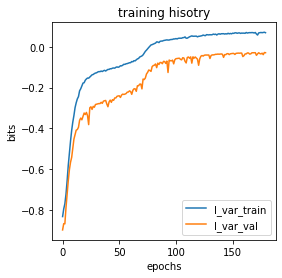

In [18]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [19]:
phi = gpmap.x_to_phi(x_test)

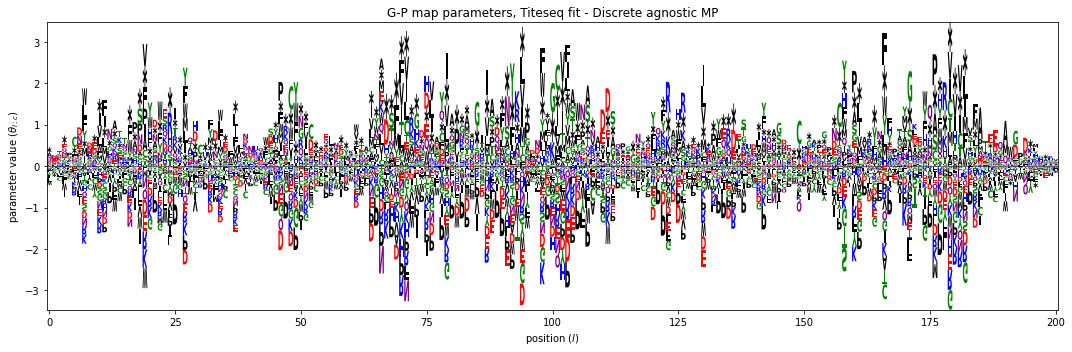

In [20]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete agnostic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DA-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [25]:
sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
titeseq_gpmap = np.load('titeseq_gpmap_discrete_agnostic.npy')

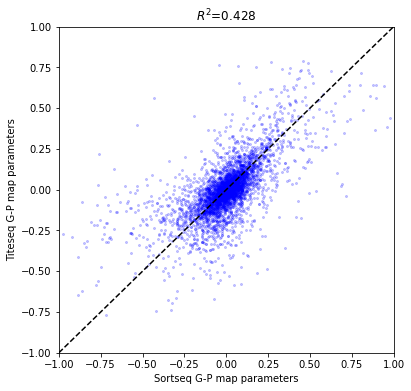

In [26]:
plt.figure(figsize=(6,6))
# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# Style plot
xlim = [-1, 1]

plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
plt.xlabel('Sortseq G-P map parameters')
plt.ylabel('Titeseq G-P map parameters')
plt.title(f'$R^2$={Rsq:.3}');
plt.plot(xlim, xlim, '--', color='k', label='diagonal')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

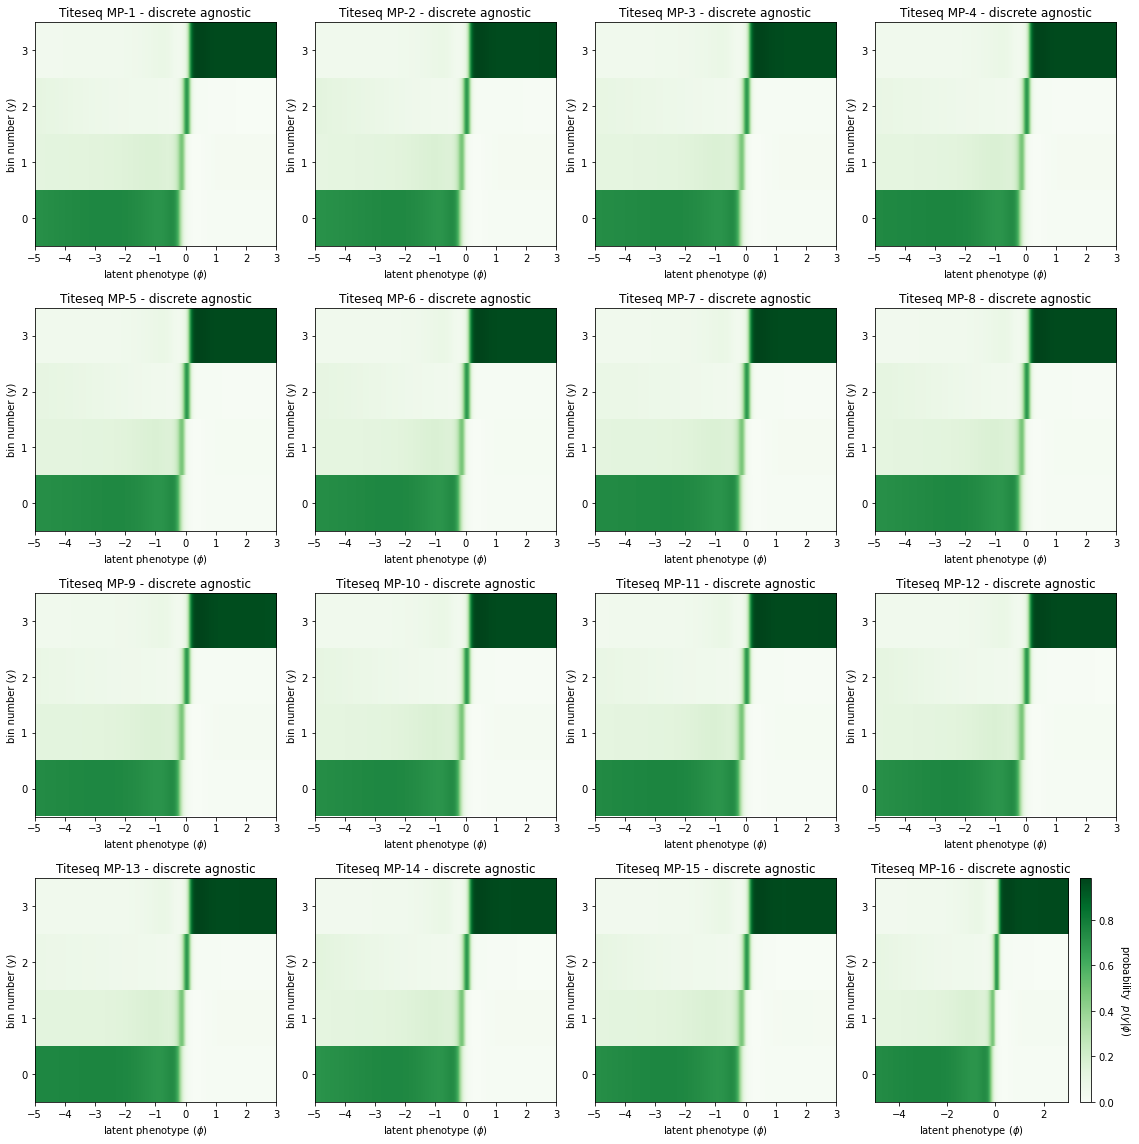

In [27]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete agnostic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

#fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')
